In [3]:
import torch
import torch.fft
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp

from dataprocess.sirst import IRSTD1kDataset
# from dataprocess.sirst_point import IRSTD1kDataset
import torch.utils.data as Data
import yaml
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import cv2

from net.attentionnet import attenMultiplyUNet_withloss

cfg_path = 'cfg.yaml'
with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

trainset = IRSTD1kDataset(base_dir=r"W:/DataSets/ISTD/IRSTD-1k", mode="train", base_size=256, pseudo_label=True, cfg=cfg)
train_data_loader = Data.DataLoader(trainset, batch_size=32, shuffle=False, drop_last=False)

In [4]:
def img_gradient(image_batch):
    # 定义 Sobel 算子
    sobel = torch.tensor([[[[-0.25, 0., 0.25],
                            [-2., 0., 2.],
                            [-0.25, 0., 0.25]]],
                          [[[ 0.25, 2., 0.25],
                            [ 0., 0., 0.],
                            [-0.25,-2.,-0.25]]],
                          [[[ 2., 0.25, 0.],
                            [ 0.25, 0.,-0.25],
                            [ 0.,-0.25,-2.]]],
                          [[[ 0., 0.25, 2.],
                            [-0.25, 0., 0.25],
                            [-2.,-0.25, 0.]]]], dtype=image_batch.dtype, device=image_batch.device)
    gradient = F.conv2d(image_batch, sobel, padding=1)  # (B, 4, S, S)
    zeros_tensor = torch.zeros_like(gradient[:,:1])
    grad_top = torch.where(gradient[:,1:2]>0, gradient[:,1:2], zeros_tensor)
    grad_topleft = torch.where(gradient[:,2:3]>0, gradient[:,2:3], zeros_tensor)
    grad_topright = torch.where(gradient[:,3:4]>0, gradient[:,3:4], zeros_tensor)
    grad_right = torch.where(gradient[:,:1]>0, gradient[:,:1], zeros_tensor)
    grad_bot = torch.where(gradient[:,1:2]<0, -gradient[:,1:2], zeros_tensor)
    grad_botleft = torch.where(gradient[:,2:3]<0, -gradient[:,2:3], zeros_tensor)
    grad_botright = torch.where(gradient[:,3:4]<0, -gradient[:,3:4], zeros_tensor)
    grad_left = torch.where(gradient[:,:1]<0, -gradient[:,:1], zeros_tensor)
    grad = torch.concatenate((grad_top, grad_bot, grad_right, grad_left, grad_topleft, grad_botright, grad_topright, grad_botleft), dim=1)
    grad[:,:,:1]=0
    grad[:,:,-1:]=0
    grad[:,:,:,:1]=0
    grad[:,:,:,-1:]=0
    return grad

def  gradient_expand(gradient, rate):
    op1 = torch.tensor([[[[0.9, 0.05, 0.0],
                          [0.05, 0.0, 0.0],
                          [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate
    op2 = torch.tensor([[[[0.05, 0.9, 0.05],
                          [0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate
    op3 = torch.tensor([[[[0.05, 0.0, 0.0],
                          [0.9, 0.0, 0.0],
                          [0.05, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate

    grad_top = F.conv2d(gradient[:,:1], torch.flip(op2, dims=[2]), padding=1)
    grad_bot = F.conv2d(gradient[:,1:2], op2, padding=1)
    grad_right = F.conv2d(gradient[:,2:3], op3, padding=1)
    grad_left = F.conv2d(gradient[:,3:4], torch.flip(op3, dims=[3]), padding=1)
    grad_topleft = F.conv2d(gradient[:,4:5], torch.flip(op1, dims=[2,3]), padding=1)
    grad_botright = F.conv2d(gradient[:,5:6], op1, padding=1)
    grad_topright = F.conv2d(gradient[:,6:7], torch.flip(op1, dims=[2]), padding=1)
    grad_botleft = F.conv2d(gradient[:,7:8], torch.flip(op1, dims=[3]),padding=1)
    gradient_ = torch.concatenate((grad_top, grad_bot, grad_right, grad_left, grad_topleft, grad_botright, grad_topright, grad_botleft), dim=1)
    gradient_ = torch.where(gradient*rate > gradient_, gradient, gradient_)
    return gradient_

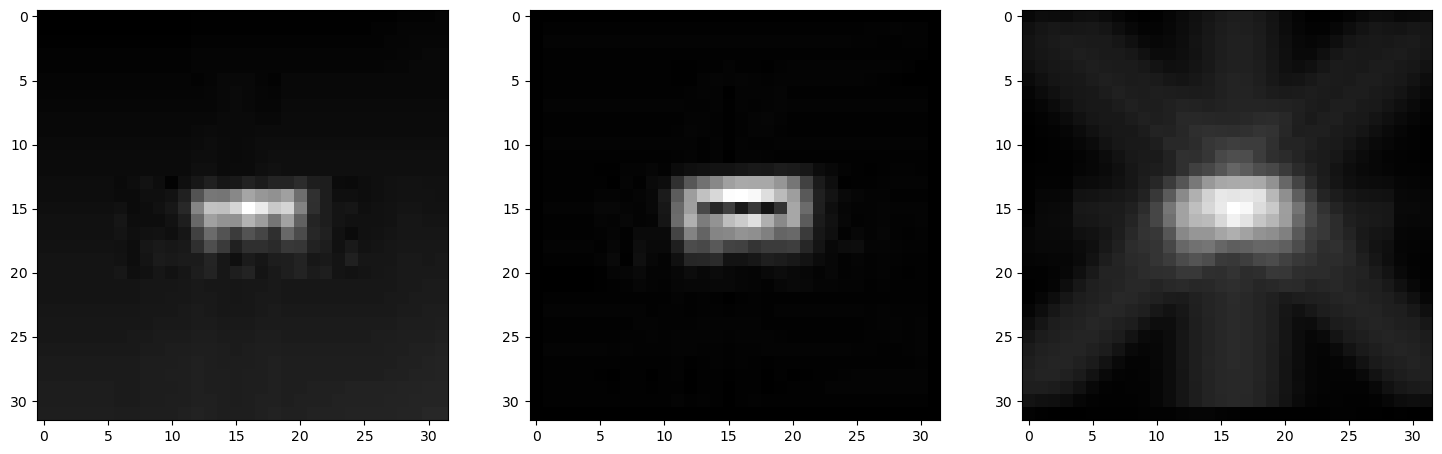

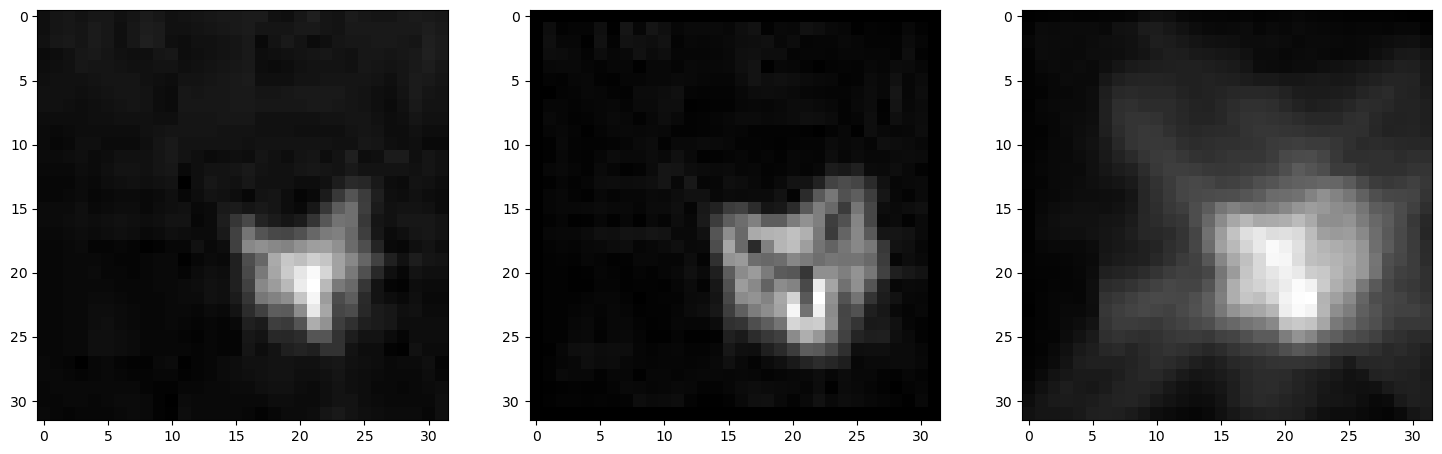

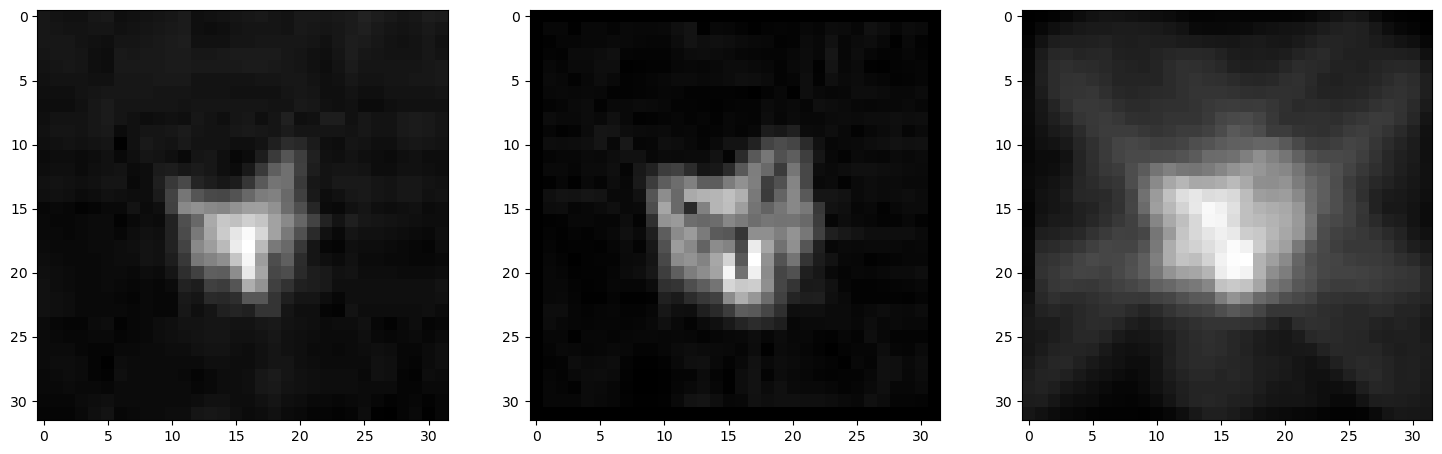

KeyboardInterrupt: Interrupted by user

In [5]:
regions = []
img_idx = -1
pre_batch_idx = -1
pre_j_idx = -1
for j, (data, label) in enumerate(train_data_loader):
    B, _, S, _ = data.shape
    indices = torch.where(label > 0.)
    region_size = 32
    half_region_size = region_size // 2

    for b, _, s1, s2 in zip(*indices):
        # 计算索引
        if b != pre_batch_idx or j != pre_j_idx:
            pre_batch_idx = b
            pre_j_idx = j
            img_idx += 1

        # 计算区域的边界
        start_s1 = max(0, s1 - half_region_size)
        end_s1 = min(S, s1 + half_region_size)
        start_s2 = max(0, s2 - half_region_size)
        end_s2 = min(S, s2 + half_region_size)
        
        # 提取区域
        region = data[b, 0, start_s1:end_s1, start_s2:end_s2]
        original_region = region.clone()
        # original_region = data.clone()[b, 0, start_s1:end_s1, start_s2:end_s2]
        # print("#######################")
        # print(region.untyped_storage(), original_region.untyped_storage())
        # a = input()

        region = region-torch.min(region)/(torch.max(region) - torch.min(region))

        img_gradient_ = img_gradient(region.unsqueeze(0).unsqueeze(0))
        expanded_grad = img_gradient_
        for i in range(16):
            expanded_grad = gradient_expand(expanded_grad, 1.0)
        
        target_info = {"original_region": original_region, "region": torch.sum(expanded_grad[0], dim=0), "img_idx": img_idx, 'height_start_idx': start_s1, 'height_end_idx':end_s1, 'width_start_idx': start_s2, 'width_end_idx':end_s2}
        regions.append(target_info)
        # # 过滤
        target = torch.sum(expanded_grad[0], dim=0)
        # mean_val = (torch.max(target) + torch.mean(target))/2
        # target = torch.where(target > mean_val, target, torch.zeros_like(target))
        # 显示结果
        plt.figure(figsize=(18, 6))
        plt.subplot(131), plt.imshow(region, cmap='gray')
        plt.subplot(132), plt.imshow(torch.sum(img_gradient_[0], dim=0), cmap='gray')
        plt.subplot(133), plt.imshow(target, cmap='gray') 
        plt.show()

        # if region.shape != (region_size, region_size):
        #     region = torch.nn.functional.pad(region, (0, region_size - region.shape[1], 0, region_size - region.shape[0]), mode='reflect')
        
        a = input()
for i in range(len(regions)):
    image_data = np.array(regions[i]["region"])
    original_image_data = np.array(regions[i]["original_region"])
    normalized_original_image_data = (original_image_data * 255).astype(np.uint8) 
    # 归一化到 0-255 范围内
    min_val = image_data.min()
    max_val = image_data.max()
    normalized_image_data = ((image_data - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    # 将 NumPy 数组转换为 PIL 图像
    image = Image.fromarray(normalized_image_data, mode='L')  # 'L' 表示灰度模式
    image_ori = Image.fromarray(normalized_original_image_data, mode='L')
    # 保存图像到本地文件
    
    path = "W:/DataSets/ISTD/IRSTD-1k/trainval/target_pseudo_label/"
    original_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/original_image/"
    base_name = "{:04d}_{:04d}_{:04d}_{:04d}_{:04d}.png"
    image.save(path + base_name.format(regions[i]["img_idx"], regions[i]["height_start_idx"], regions[i]["height_end_idx"], regions[i]["width_start_idx"], regions[i]["width_end_idx"]))
    image_ori.save(original_path + base_name.format(regions[i]["img_idx"], regions[i]["height_start_idx"], regions[i]["height_end_idx"], regions[i]["width_start_idx"], regions[i]["width_end_idx"]))

In [13]:
def load_image(image_path):
    """加载图像并转换为灰度模式"""
    image = Image.open(image_path).convert('L')
    return np.array(image)

def calculate_histogram(image):
    """计算图像的亮度直方图"""
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    return hist, bins[:-1]

def smooth_histogram(hist, sigma=10, window_size=10):
    """多步平滑直方图"""
    # 使用移动平均滤波器进行初步平滑
    moving_avg_hist = np.convolve(hist, np.ones(window_size)/window_size, mode='same')
    
    # 使用高斯滤波器进行最终平滑
    smoothed_hist = gaussian_filter1d(moving_avg_hist, sigma=sigma)
    
    return smoothed_hist

def find_last_valley(hist):
    """查找直方图中的最后一个低谷"""
    # 这里简单地通过寻找直方图中从后向前的第一个极小值点来确定低谷
    for i in range(len(hist)-2, 0, -1):
        if hist[i] < hist[i-1] and hist[i] < hist[i+1]:
            return i
    return None

def find_first_major_peak_and_valley(hist):
    """查找直方图中的第一个大波峰及其后的第一个大低谷"""
    # 平滑直方图
    smoothed_hist = smooth_histogram(hist)
    
    # 找到波峰
    peaks, _ = find_peaks(smoothed_hist, distance=10, prominence=1)
    
    if len(peaks) == 0:
        # return None, None
        for i in range(len(smoothed_hist)):
            if smoothed_hist[i] <= 1:
                break
        return None, i
    
    
    first_peak = peaks[0]
    
    # 从第一个波峰开始找到第一个大低谷
    valleys, _ = find_peaks(-smoothed_hist[first_peak:], distance=10)
    
    if len(valleys) == 0:
        # return first_peak, None
        pixel_num = 0
        i = 0
        for i in range(len(hist)-2, 0, -1):
            if pixel_num > 256:
                break
            pixel_num += hist[i]
        return first_peak, i
        
        
    first_valley = first_peak + valleys[0]
    
    return first_peak, first_valley

def filter_image(image, threshold):
    """根据阈值过滤图像"""
    filtered_image = image.copy()
    filtered_image[image < threshold] = 0  # 将低于阈值的像素设为黑色
    return filtered_image

path = "W:/DataSets/ISTD/IRSTD-1k/trainval/target_pseudo_label"
ori_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/original_image"
pixel_pseudo_label_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/pixel_pseudo_label"
img_idx= 0
pseudo_labels = [[],]
for filename in os.listdir(path):
    # 确定图片所属数据集图片的文件名
    target_info = filename.split('_')
    num = int(target_info[0])
    if num != img_idx:
        pseudo_labels.append([])
        img_idx += 1
    # 加载图像
    image_path = path + '/' + filename
    image = load_image(image_path)
    
    # 计算直方图
    hist, bins = calculate_histogram(image)

    # 查找第一个山峰及其后的第一个低谷
    first_peak, first_valley = find_first_major_peak_and_valley(hist)
    # print(f"First peak found at brightness level: {first_peak}")
    # print(f"First valley after the first peak found at brightness level: {first_valley}")
    
    # 根据低谷过滤图像
    if first_valley is not None:
        filtered_image = filter_image(image, first_valley)
    else:
        filtered_image = image  # 如果没有找到低谷，则不进行过滤
    
    pseudo_labels[-1].append({"filtered_image": filtered_image, 'height_start_idx': int(target_info[1]), 'height_end_idx':int(target_info[2]), 'width_start_idx': int(target_info[3]), 'width_end_idx':int(target_info[4].split('.')[0])})
    
    # # 保存图像
    # filtered_image = Image.fromarray(filtered_image, mode='L')  # 'L' 表示灰度模式
    # image.save(pixel_pseudo_label_path + '/' + filename)

    # # 绘制直方图
    # plt.figure(figsize=(20, 5))
    
    # # 原始图像
    # plt.subplot(1, 4, 1)
    # plt.imshow(image, cmap='gray')
    # plt.title('Original Image')
    # plt.axis('off')
    
    # # 直方图
    # plt.subplot(1, 4, 2)
    # plt.bar(bins, hist, color='blue', alpha=0.7, label='Histogram')
    # smoothed_hist = smooth_histogram(hist)
    # plt.plot(bins, smoothed_hist, color='orange', label='Smoothed Histogram')
    # if first_peak is not None:
    #     plt.axvline(x=first_peak, color='green', linestyle='--', label=f'First Major Peak: {first_peak}')
    # if first_valley is not None:
    #     plt.axvline(x=first_valley, color='red', linestyle='--', label=f'First Major Valley: {first_valley}')
    # plt.legend()
    # plt.title('Brightness Histogram')
    # plt.xlabel('Brightness Level')
    # plt.ylabel('Pixel Count')
    
    # # 过滤后的图像
    # plt.subplot(1, 4, 3)
    # plt.imshow(filtered_image, cmap='gray')
    # plt.title('Filtered Image')
    # plt.axis('off')

    # # 展示对齐效果
    # # 加载原图（假设为灰度图）
    # image_path = ori_path + '/' + filename
    # image = np.array(Image.open(image_path).convert('L'))

    # # 加载或生成掩码（假设为二值图，0为背景，255为目标区域）
    # mask = ((filtered_image > 0)*255).astype(np.uint8)

    # # 将灰度图转换为RGB图
    # image_rgb = np.stack([mask, image, image], axis=-1)

    # plt.subplot(1, 4, 4)
    # plt.imshow(image_rgb)
    # plt.title('Overlap')
    # plt.axis('off')
    
    # plt.tight_layout()
    # plt.show()

    # a = input()

pesudo_labels_ = []
origin_name = os.listdir("W:/DataSets/ISTD/IRSTD-1k/trainval/images")
for i in range(len(pseudo_labels)):
    pseudo_label = np.zeros((512, 512))
    for j in pseudo_labels[i]:
        print(j["height_start_idx"], j["height_end_idx"], j["width_start_idx"],j["width_end_idx"], j["filtered_image"].shape)
        pseudo_label[j["height_start_idx"]: j["height_end_idx"], j["width_start_idx"]: j["width_end_idx"]] = j["filtered_image"]
    # plt.imshow(pseudo_label, cmap='gray')
    # plt.title(origin_name[i])
    # plt.show()
    pseudo_label_image = Image.fromarray(pseudo_label.astype(np.uint8), mode='L')  # 'L' 表示灰度模式
    pseudo_label_image.save(pixel_pseudo_label_path + '/' + origin_name[i])

411 443 250 282 (32, 32)
237 269 98 130 (32, 32)
240 272 103 135 (32, 32)
275 307 92 124 (32, 32)
302 334 41 73 (32, 32)
270 302 50 82 (32, 32)
58 90 310 342 (32, 32)
2 34 143 175 (32, 32)
220 252 203 235 (32, 32)
5 37 189 221 (32, 32)
7 39 194 226 (32, 32)
77 109 178 210 (32, 32)
376 408 385 417 (32, 32)
443 475 392 424 (32, 32)
117 149 395 427 (32, 32)
158 190 156 188 (32, 32)
284 316 399 431 (32, 32)
114 146 164 196 (32, 32)
182 214 62 94 (32, 32)
224 256 370 402 (32, 32)
275 307 385 417 (32, 32)
259 291 341 373 (32, 32)
312 344 349 381 (32, 32)
335 367 255 287 (32, 32)
364 396 268 300 (32, 32)
255 287 198 230 (32, 32)
338 370 177 209 (32, 32)
43 75 261 293 (32, 32)
121 153 401 433 (32, 32)
45 77 151 183 (32, 32)
114 146 359 391 (32, 32)
376 408 108 140 (32, 32)
378 410 210 242 (32, 32)
139 171 279 311 (32, 32)
176 208 277 309 (32, 32)
225 257 310 342 (32, 32)
89 121 246 278 (32, 32)
242 274 42 74 (32, 32)
352 384 114 146 (32, 32)
419 451 13 45 (32, 32)
46 78 114 146 (32, 32)
50 82 

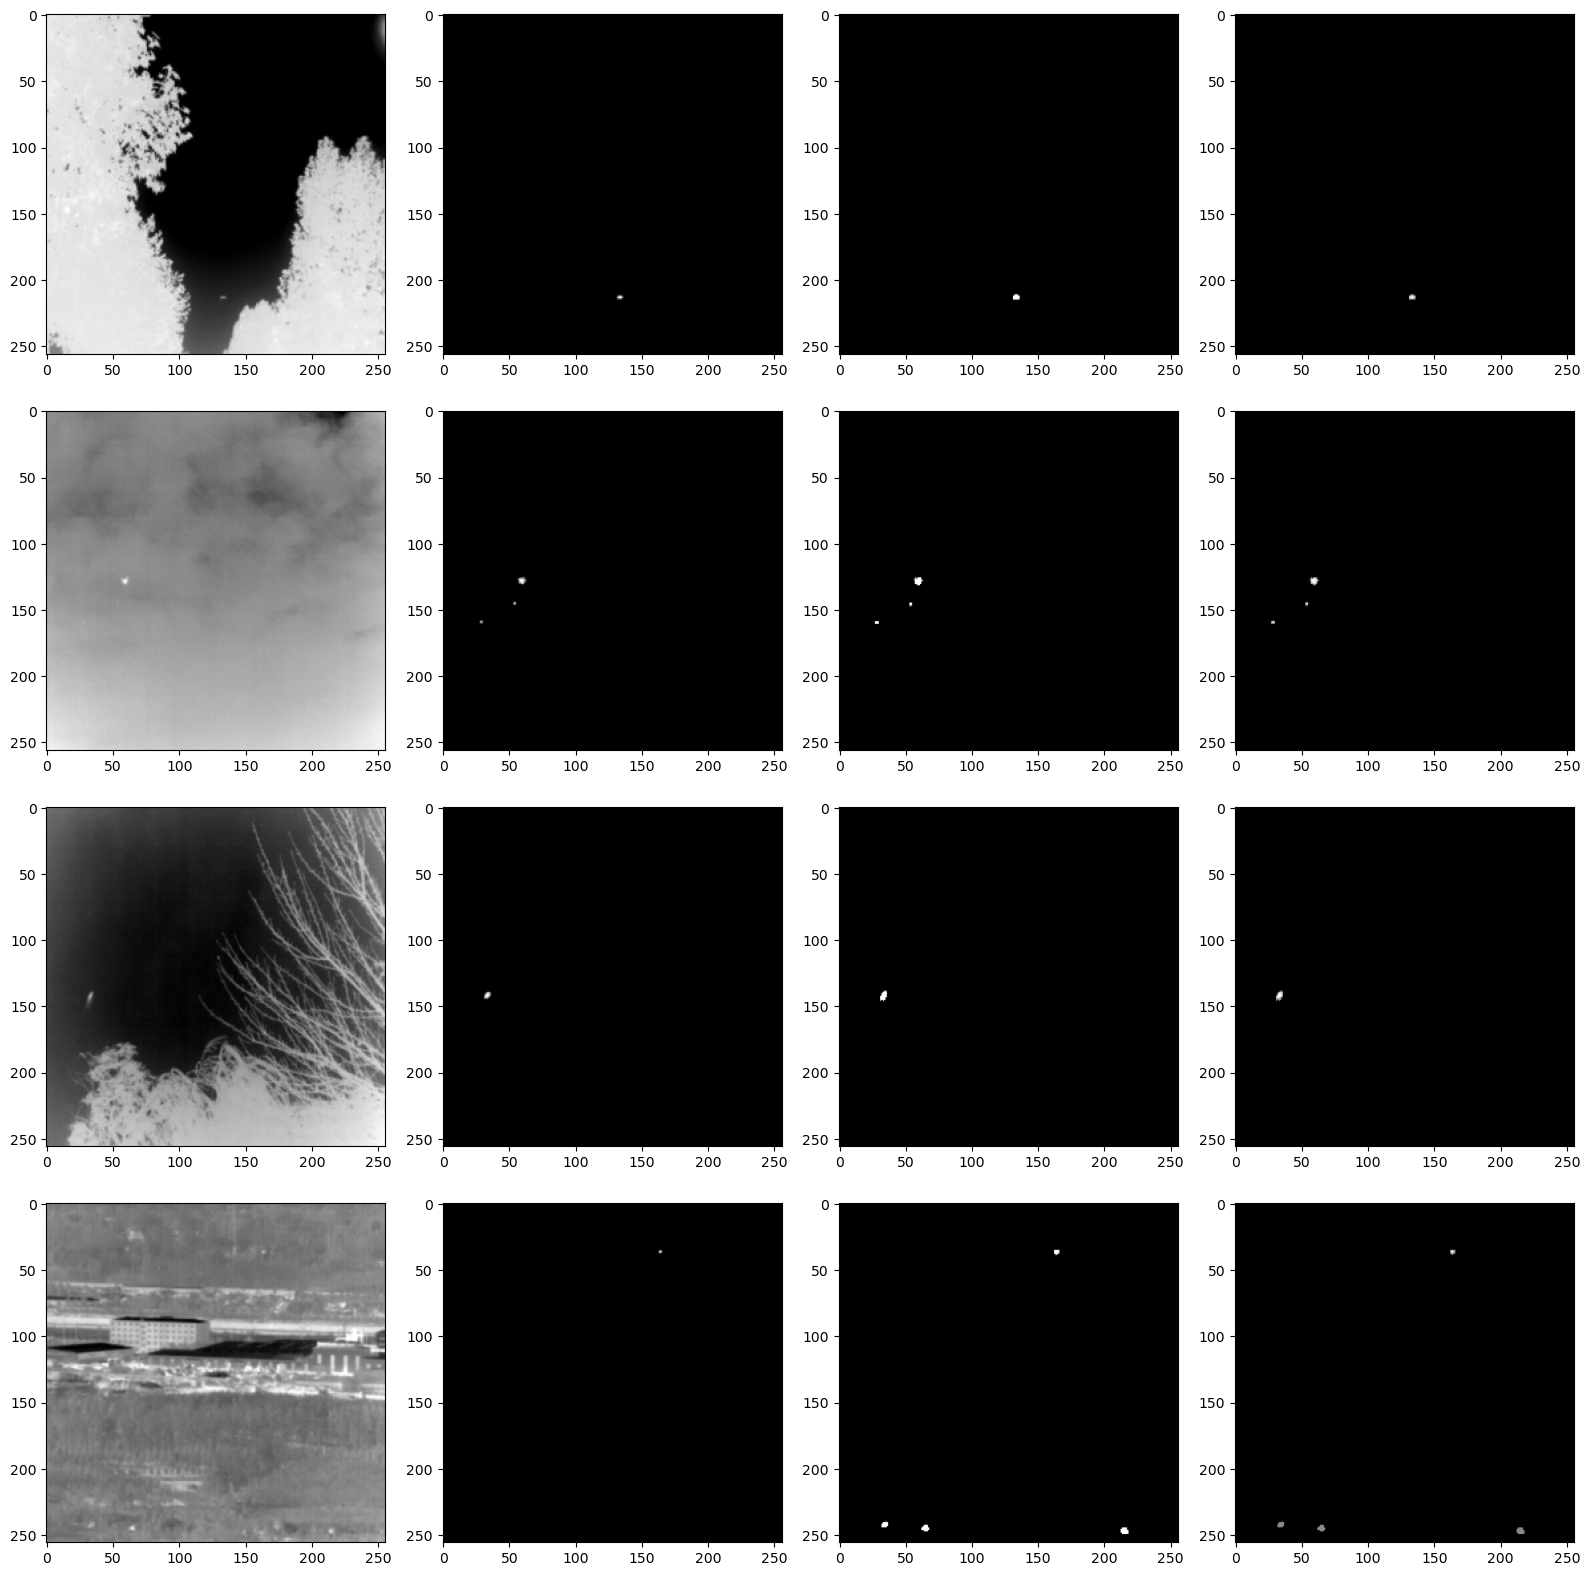

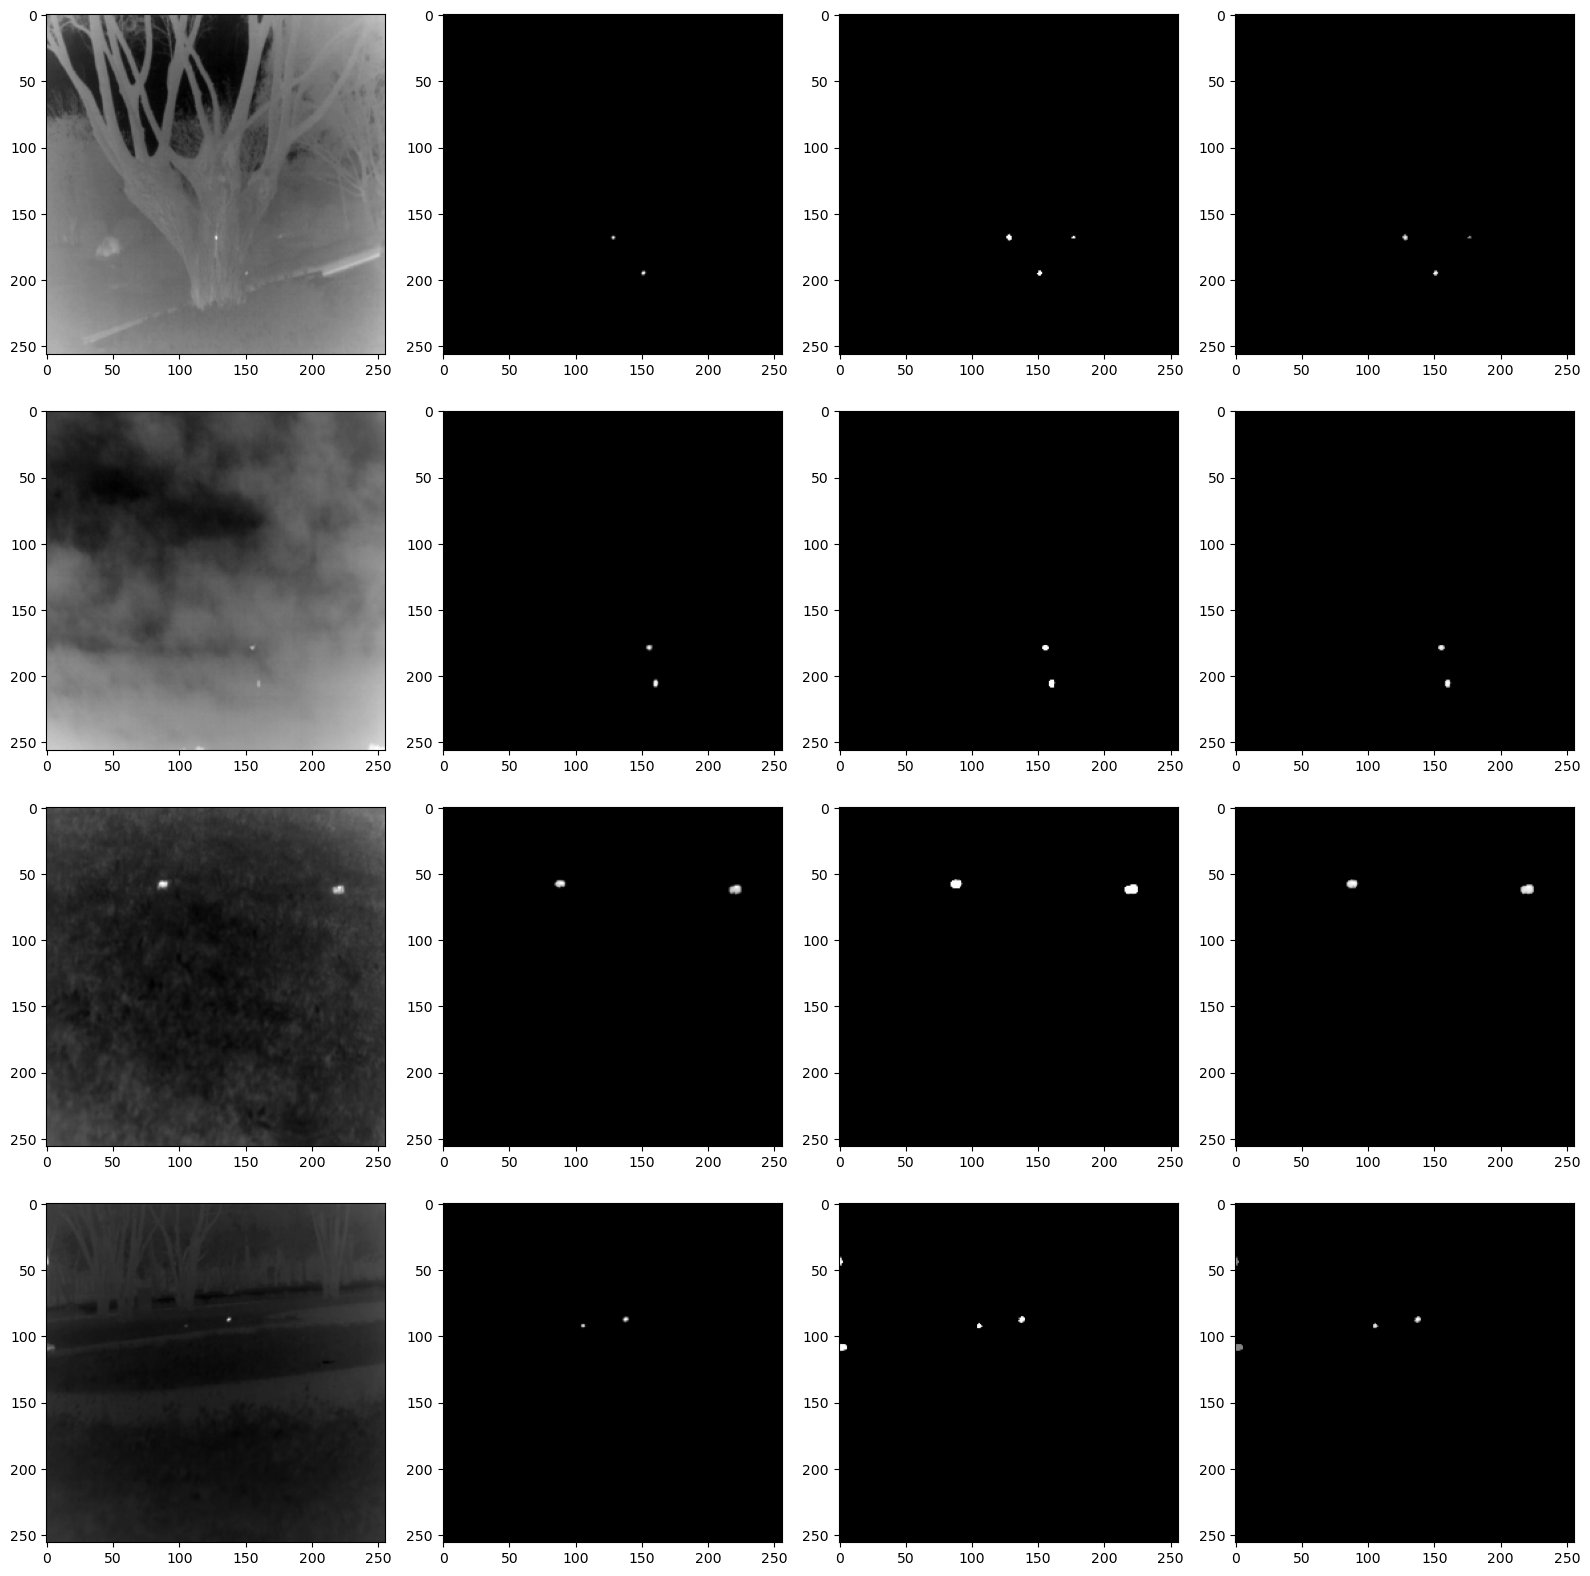

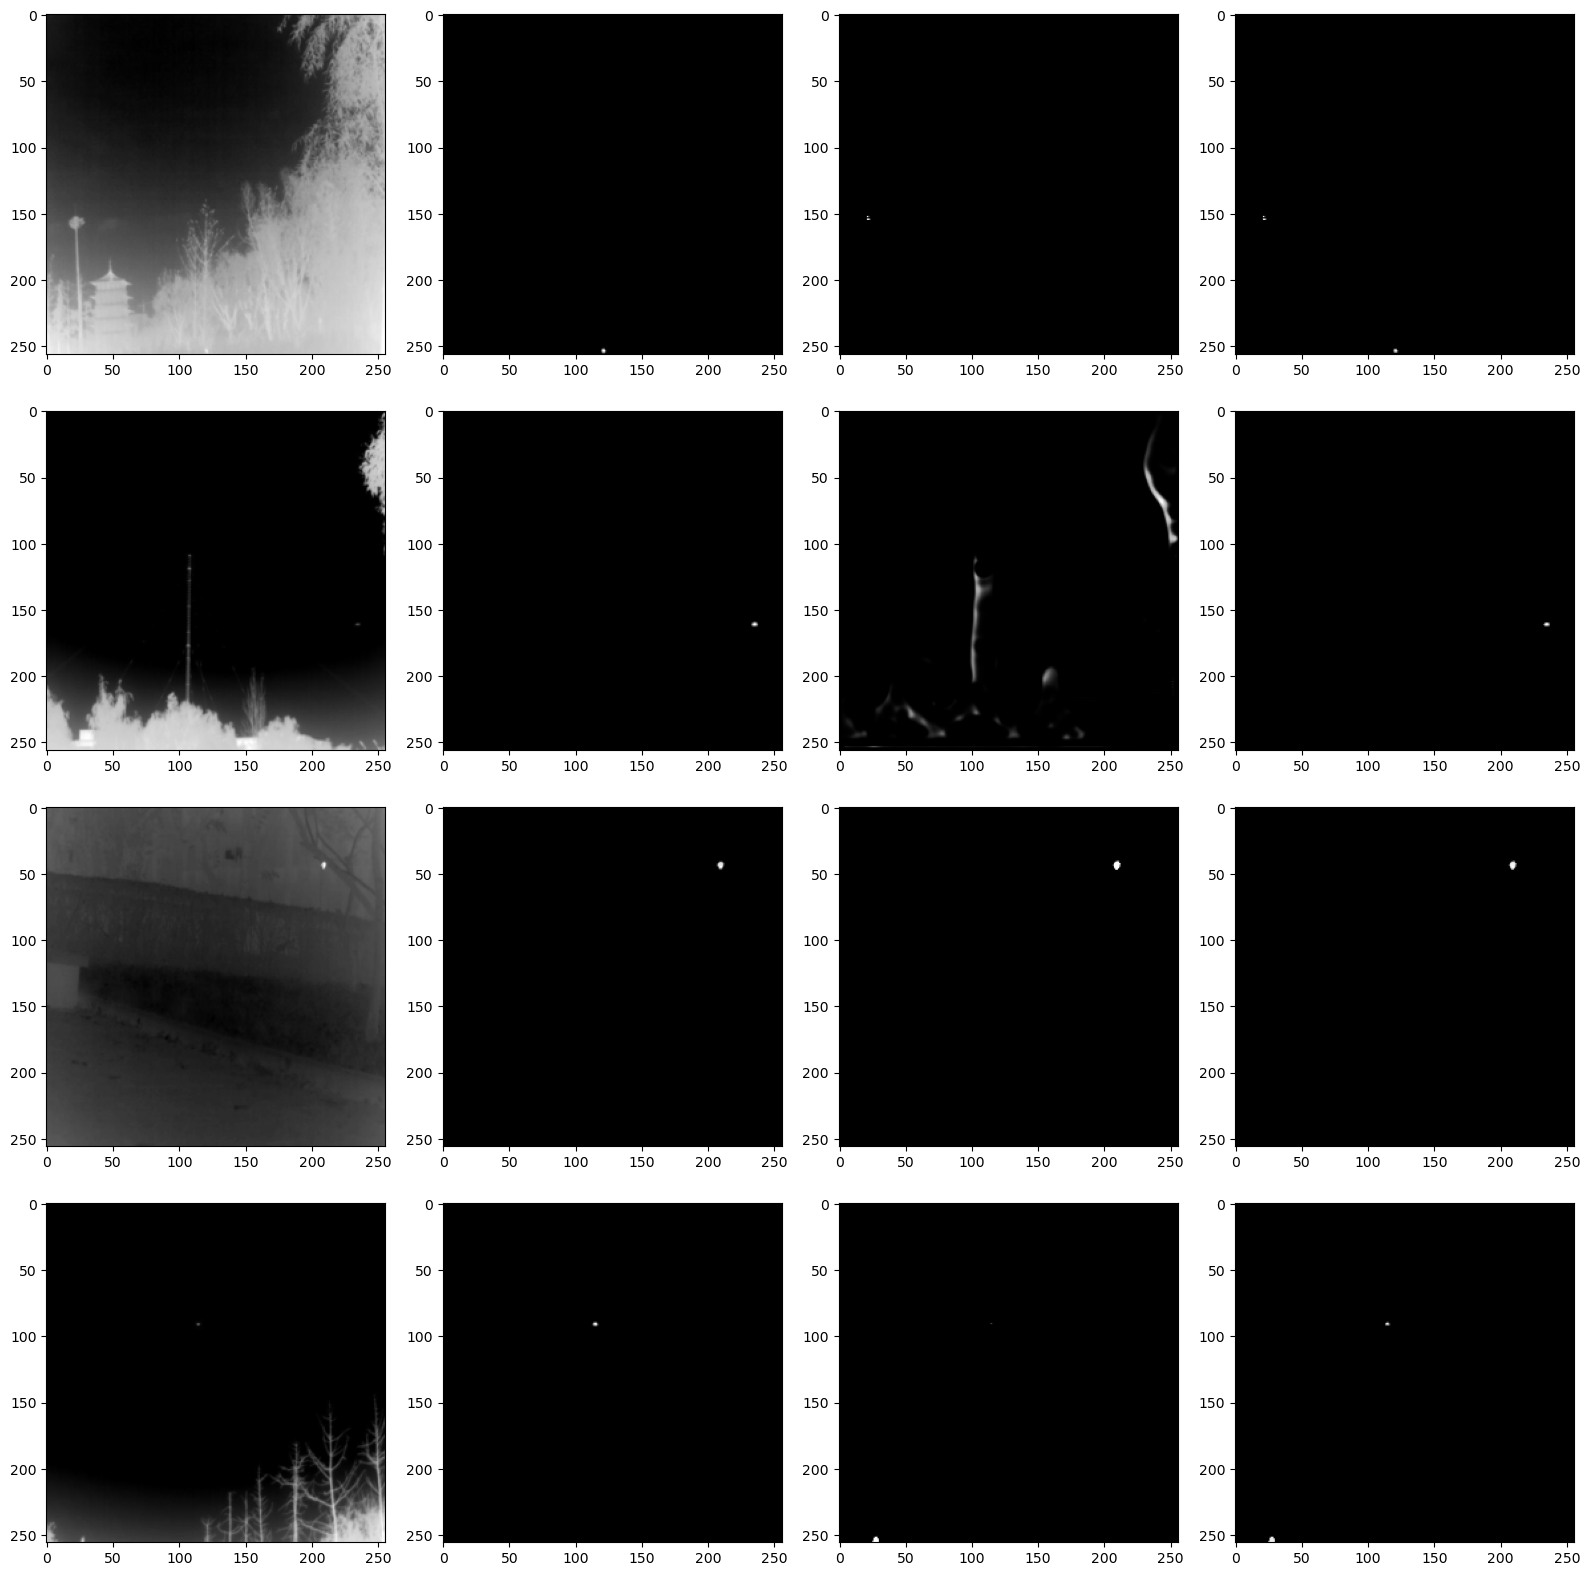

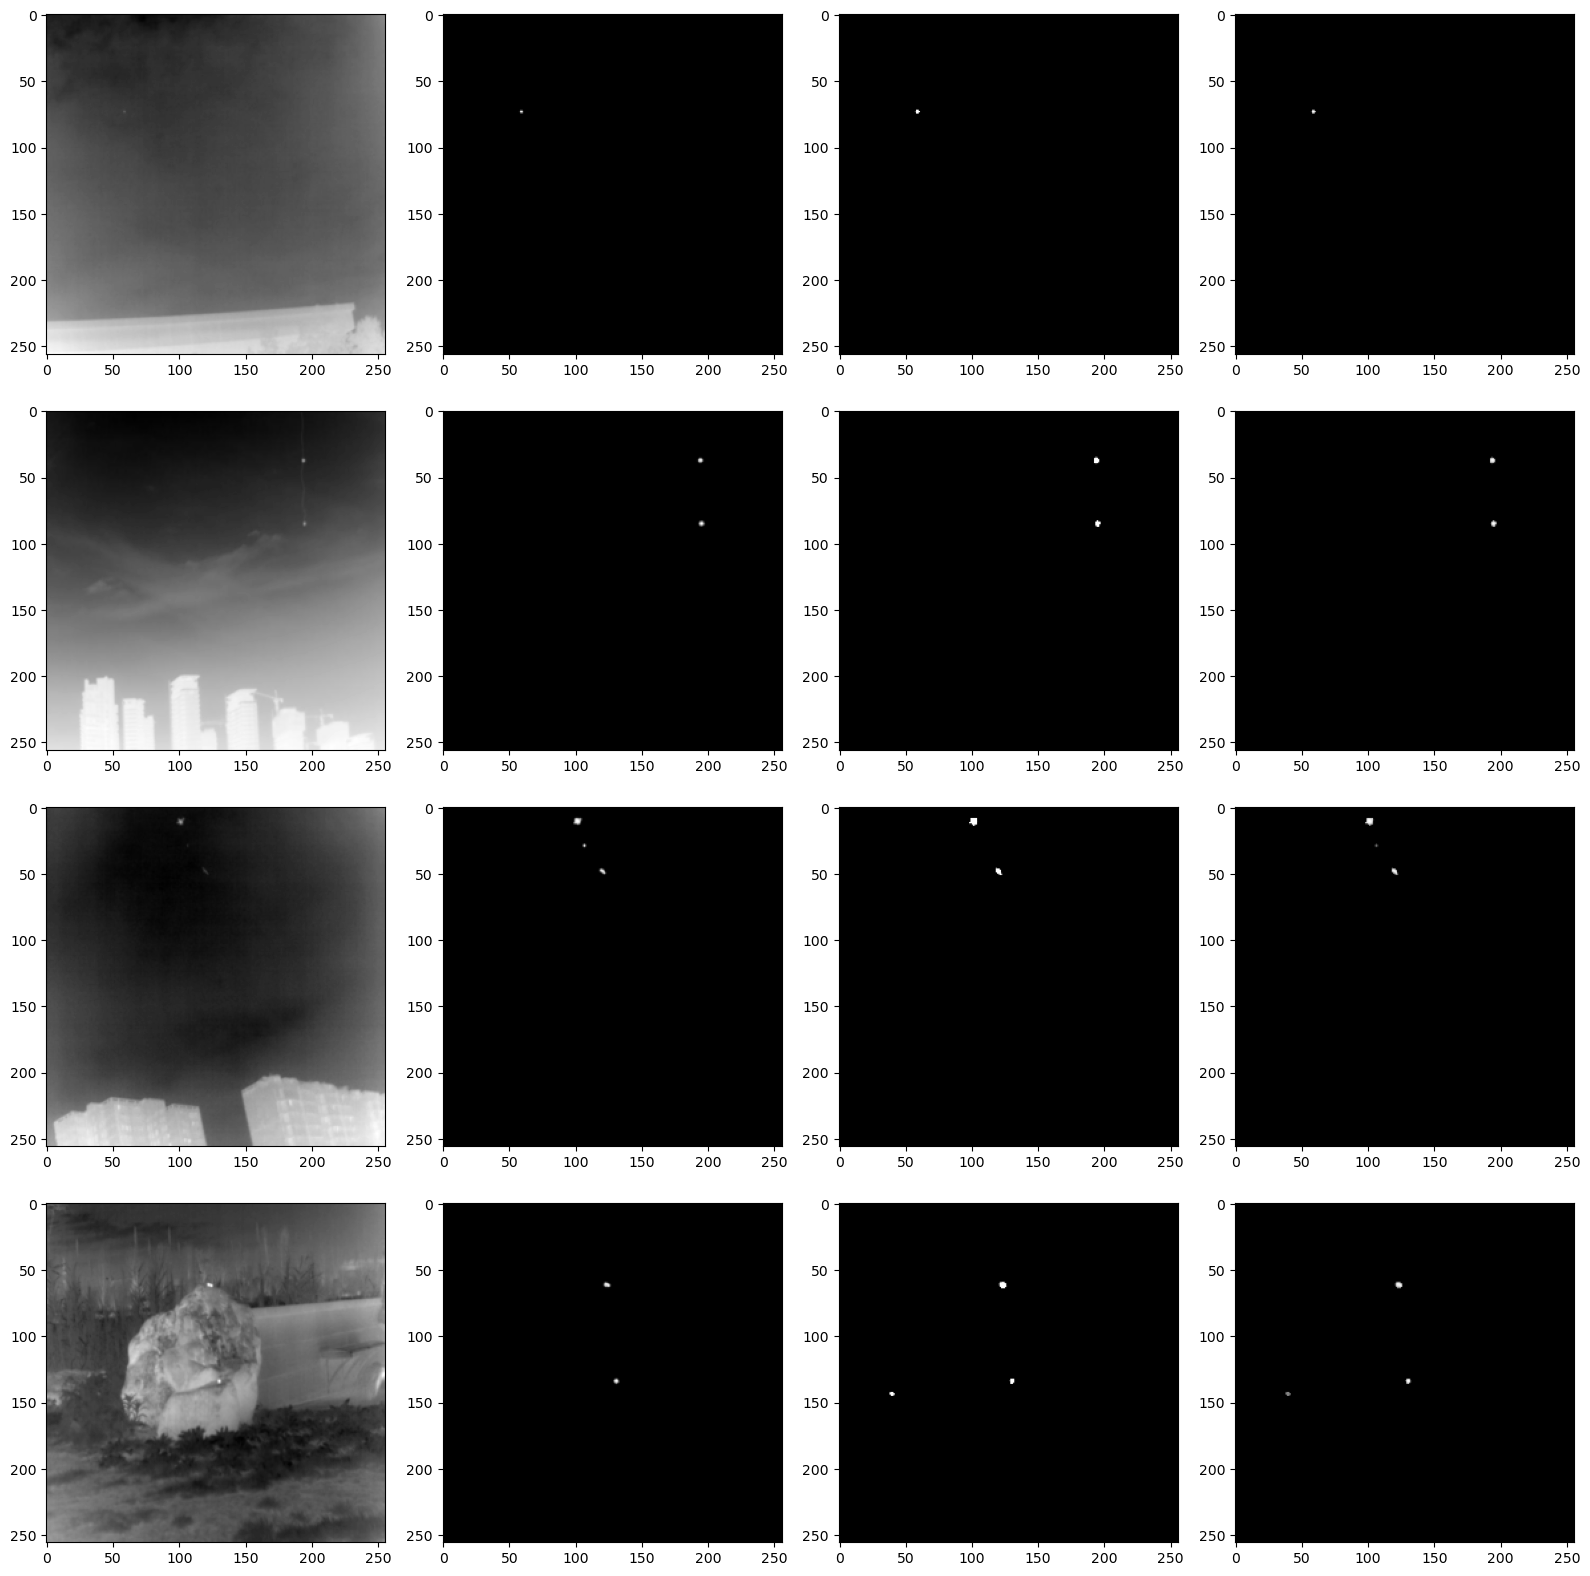

KeyboardInterrupt: Interrupted by user

In [8]:
net_path = "W:/Projects/infraredDimTargetDetection/result/20241114T12-10-17_ws_GE_irstd1k/best.pkl"
net = attenMultiplyUNet_withloss(cfg, False)
net.load_state_dict(torch.load(net_path))
net = net.net.to('cuda')

new_pseudo_label = []
for j, (data, label) in enumerate(train_data_loader):
    data = data.to('cuda')
    preds, _, _, _ = net(data)
    preds = preds.cpu().detach()
    
    pseudo_label = (preds + label) / 2
    pseudo_label = pseudo_label * (pseudo_label > 0.1)

    data = data.cpu()

    row_num = 4
    col_num = 4
    fig, axes = plt.subplots(row_num, col_num, figsize=(col_num*4, row_num*4))
    for i in range(row_num):
        axes[i, 0].imshow(data[i,0], cmap='gray')
        # axes[i, 1].imshow(img_gradient_[i, 0], cmap='gray')
        # axes[i, 2].imshow(expanded_grad[i, 0], cmap='gray')
        # axes[i, 3].imshow(img_gradient_[i, 2], cmap='gray')
        # axes[i, 4].imshow(img_gradient_[i, 3], cmap='gray')
        # axes[i, 5].imshow(img_gradient_[i, 4], cmap='gray')
        # axes[i, 6].imshow(img_gradient_[i, 5], cmap='gray')
        # axes[i, 7].imshow(img_gradient_[i, 6], cmap='gray')
        # axes[i, 8].imshow(img_gradient_[i, 7], cmap='gray')
        axes[i, 1].imshow(label[i, 0], cmap='gray')
        axes[i, 2].imshow(preds[i, 0], cmap='gray')
        axes[i, 3].imshow(pseudo_label[i, 0], cmap='gray')
    plt.tight_layout()
    plt.show()
    a = input()
    

    

In [14]:
origin_name = os.listdir("W:/DataSets/ISTD/IRSTD-1k/trainval/images")
for i in range(len(origin_name)):
    if origin_name[i] == "XDU263.png":
        print(i)

143


In [ ]:
trainset = IRSTD1kDataset(base_dir=r"W:/DataSets/ISTD/IRSTD-1k", mode="train", base_size=256, cfg=cfg)
train_data_loader = Data.DataLoader(trainset, batch_size=8, shuffle=False)

def img_gradient(image_batch):
    # 定义 Sobel 算子
    sobel = torch.tensor([[[[-0.25, 0., 0.25],
                            [-2., 0., 2.],
                            [-0.25, 0., 0.25]]],
                          [[[ 0.25, 2., 0.25],
                            [ 0., 0., 0.],
                            [-0.25,-2.,-0.25]]],
                          [[[ 2., 0.25, 0.],
                            [ 0.25, 0.,-0.25],
                            [ 0.,-0.25,-2.]]],
                          [[[ 0., 0.25, 2.],
                            [-0.25, 0., 0.25],
                            [-2.,-0.25, 0.]]]], dtype=image_batch.dtype, device=image_batch.device)
    gradient = F.conv2d(image_batch, sobel, padding=1)  # (B, 4, S, S)
    zeros_tensor = torch.zeros_like(gradient[:,:1])
    grad_top = torch.where(gradient[:,1:2]>0, gradient[:,1:2], zeros_tensor)
    grad_topleft = torch.where(gradient[:,2:3]>0, gradient[:,2:3], zeros_tensor)
    grad_topright = torch.where(gradient[:,3:4]>0, gradient[:,3:4], zeros_tensor)
    grad_right = torch.where(gradient[:,:1]>0, gradient[:,:1], zeros_tensor)
    grad_bot = torch.where(gradient[:,1:2]<0, -gradient[:,1:2], zeros_tensor)
    grad_botleft = torch.where(gradient[:,2:3]<0, -gradient[:,2:3], zeros_tensor)
    grad_botright = torch.where(gradient[:,3:4]<0, -gradient[:,3:4], zeros_tensor)
    grad_left = torch.where(gradient[:,:1]<0, -gradient[:,:1], zeros_tensor)
    grad = torch.concatenate((grad_top, grad_bot, grad_right, grad_left, grad_topleft, grad_botright, grad_topright, grad_botleft), dim=1)
    grad[:,:,:1]=0
    grad[:,:,-1:]=0
    grad[:,:,:,:1]=0
    grad[:,:,:,-1:]=0
    return grad

def  gradient_expand(gradient, rate):
    op1 = torch.tensor([[[[0.9, 0.05, 0.0],
                          [0.05, 0.0, 0.0],
                          [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate
    op2 = torch.tensor([[[[0.05, 0.9, 0.05],
                          [0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate
    op3 = torch.tensor([[[[0.05, 0.0, 0.0],
                          [0.9, 0.0, 0.0],
                          [0.05, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate

    grad_top = F.conv2d(gradient[:,:1], torch.flip(op2, dims=[2]), padding=1)
    grad_bot = F.conv2d(gradient[:,1:2], op2, padding=1)
    grad_right = F.conv2d(gradient[:,2:3], op3, padding=1)
    grad_left = F.conv2d(gradient[:,3:4], torch.flip(op3, dims=[3]), padding=1)
    grad_topleft = F.conv2d(gradient[:,4:5], torch.flip(op1, dims=[2,3]), padding=1)
    grad_botright = F.conv2d(gradient[:,5:6], op1, padding=1)
    grad_topright = F.conv2d(gradient[:,6:7], torch.flip(op1, dims=[2]), padding=1)
    grad_botleft = F.conv2d(gradient[:,7:8], torch.flip(op1, dims=[3]),padding=1)
    gradient_ = torch.concatenate((grad_top, grad_bot, grad_right, grad_left, grad_topleft, grad_botright, grad_topright, grad_botleft), dim=1)
    gradient_ = torch.where(gradient*rate > gradient_, gradient, gradient_)
    return gradient_

def dilate_labels(labels, dilation_kernel_size=5):
    # 创建一个膨胀内核
    kernel = torch.ones(1, 1, dilation_kernel_size, dilation_kernel_size, device=labels.device)
    
    # 应用膨胀操作
    dilated_labels = F.conv2d(labels, kernel, padding=dilation_kernel_size//2)
    dilated_labels = (dilated_labels > 0).float()  # 转换为二值标签
    
    return dilated_labels
"""
def gradient_optim(gradient): 
    b, c, s, _ = gradient.shape
    kernnel_size = 64
    max_num = F.max_pool2d(gradient, kernnel_size, kernnel_size//2, kernnel_size//2)
    min_num = - F.max_pool2d(-gradient, kernnel_size, kernnel_size//2, kernnel_size//2)
    max_num = F.interpolate(max_num, scale_factor=int(kernnel_size//2))
    min_num = F.interpolate(min_num, scale_factor=int(kernnel_size//2))
    max_num = max_num[:,:,kernnel_size//4:-kernnel_size//4, kernnel_size//4:-kernnel_size//4]
    min_num = min_num[:,:,kernnel_size//4:-kernnel_size//4, kernnel_size//4:-kernnel_size//4]
    gradient = torch.where(max_num-min_num > 0.5, gradient, torch.zeros_like(gradient))
    # mean_num = torch.mean((max_num-min_num).view(b,c,s*s), dim=2)
    # avg_num = F.avg_pool2d(gradient, 3, 1, 1)
    _gradient = (gradient-min_num)/(max_num-min_num)
    return torch.where(_gradient>0.8, torch.ones_like(_gradient), torch.zeros_like(_gradient))
"""

'\ndef gradient_optim(gradient): \n    b, c, s, _ = gradient.shape\n    kernnel_size = 64\n    max_num = F.max_pool2d(gradient, kernnel_size, kernnel_size//2, kernnel_size//2)\n    min_num = - F.max_pool2d(-gradient, kernnel_size, kernnel_size//2, kernnel_size//2)\n    max_num = F.interpolate(max_num, scale_factor=int(kernnel_size//2))\n    min_num = F.interpolate(min_num, scale_factor=int(kernnel_size//2))\n    max_num = max_num[:,:,kernnel_size//4:-kernnel_size//4, kernnel_size//4:-kernnel_size//4]\n    min_num = min_num[:,:,kernnel_size//4:-kernnel_size//4, kernnel_size//4:-kernnel_size//4]\n    gradient = torch.where(max_num-min_num > 0.5, gradient, torch.zeros_like(gradient))\n    # mean_num = torch.mean((max_num-min_num).view(b,c,s*s), dim=2)\n    # avg_num = F.avg_pool2d(gradient, 3, 1, 1)\n    _gradient = (gradient-min_num)/(max_num-min_num)\n    return torch.where(_gradient>0.8, torch.ones_like(_gradient), torch.zeros_like(_gradient))\n'

tensor(1.7469)


KeyboardInterrupt: Interrupted by user

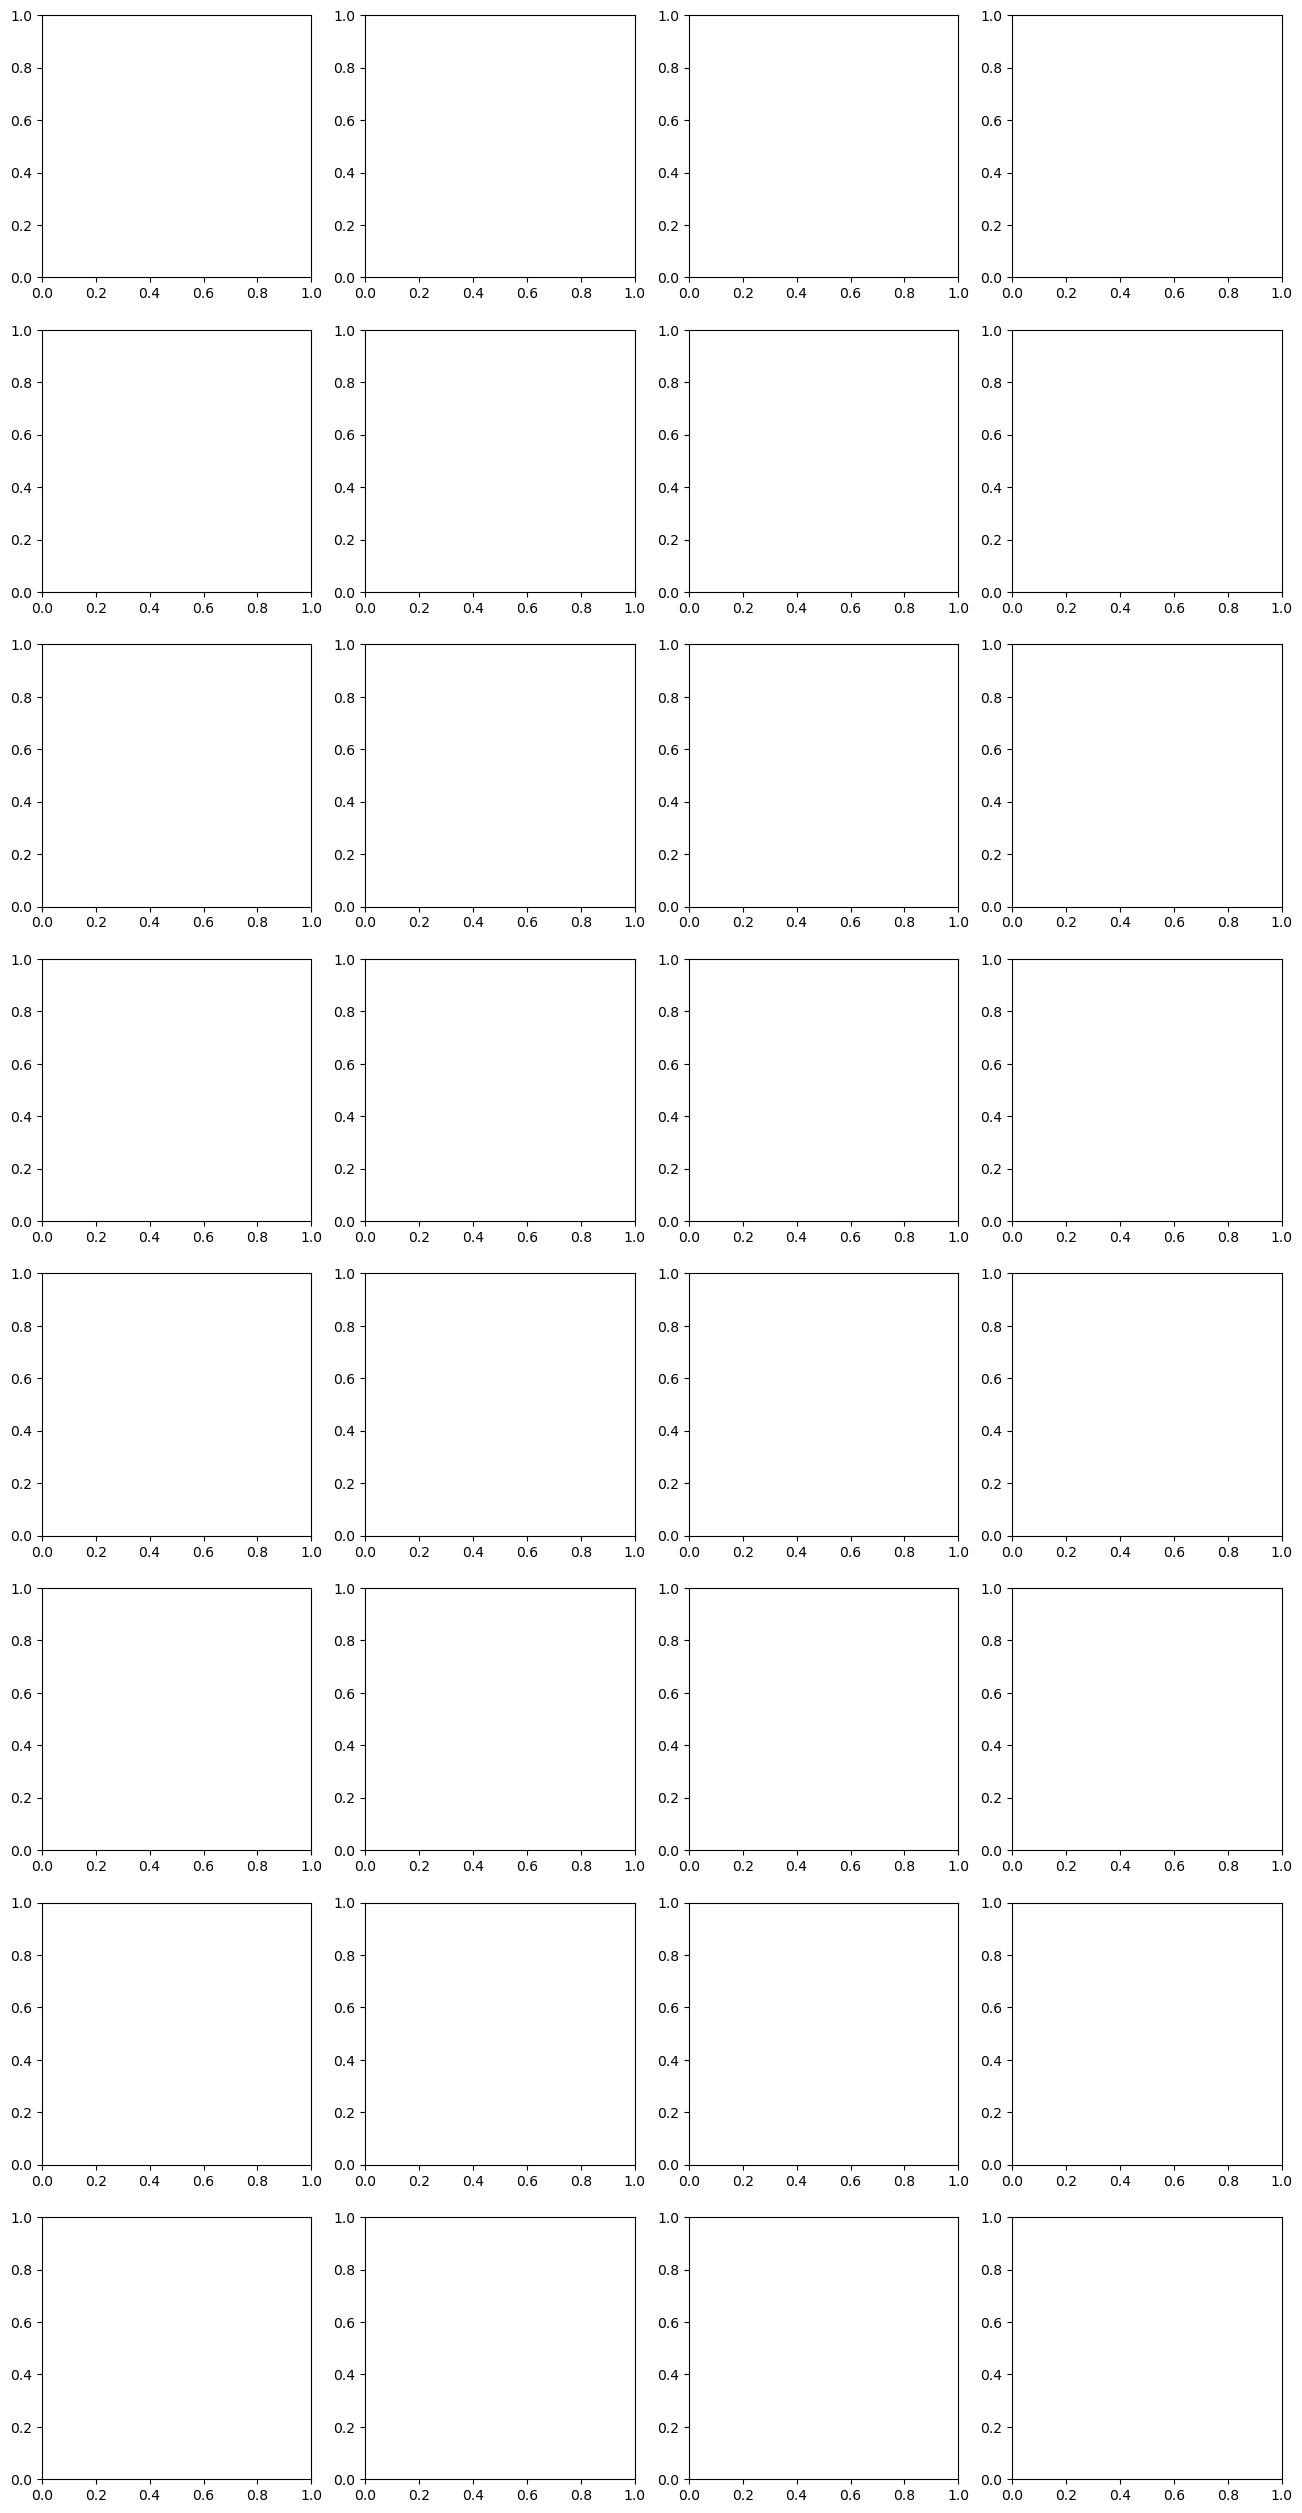

In [ ]:
for j, (data, label) in enumerate(train_data_loader):
    img_gradient_ = img_gradient(data)
    # print(torch.max(img_gradient_[0]))
    expanded_grad = img_gradient_
    for i in range(16):
        expanded_grad = gradient_expand(expanded_grad, 1.0)
    row_num = label.shape[0]
    col_num = 4
    fig, axes = plt.subplots(row_num, col_num, figsize=(col_num*4, row_num*4))
    for i in range(row_num):
        axes[i, 0].imshow(data[i,0], cmap='gray')
        # axes[i, 1].imshow(img_gradient_[i, 0], cmap='gray')
        # axes[i, 2].imshow(expanded_grad[i, 0], cmap='gray')
        # axes[i, 3].imshow(img_gradient_[i, 2], cmap='gray')
        # axes[i, 4].imshow(img_gradient_[i, 3], cmap='gray')
        # axes[i, 5].imshow(img_gradient_[i, 4], cmap='gray')
        # axes[i, 6].imshow(img_gradient_[i, 5], cmap='gray')
        # axes[i, 7].imshow(img_gradient_[i, 6], cmap='gray')
        # axes[i, 8].imshow(img_gradient_[i, 7], cmap='gray')
        axes[i, 1].imshow(torch.sum(img_gradient_[i], dim=0), cmap='gray')
        axes[i, 2].imshow(torch.sum(expanded_grad[i], dim=0), cmap='gray')
        axes[i, 3].imshow(label[i,0], cmap='gray')
    plt.tight_layout()
    plt.show()
    a = input()

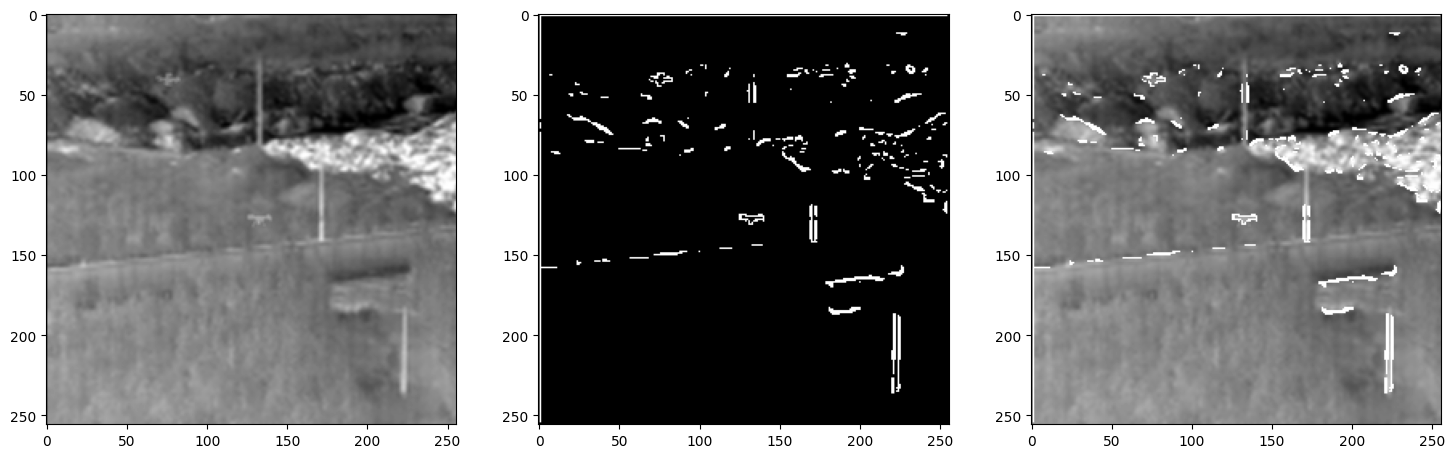

In [ ]:
# 读取图像并转换为Tensor
image_path = "W:/DataSets/ISTD/NUDT-SIRST/trainval/images/000491.png"  # 替换为你的图片路径
image = Image.open(image_path).convert('L')  # 转换为灰度图
transform = transforms.ToTensor()
tensor_image = transform(image)

# 将Tensor转换到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor_image = tensor_image.to(device)

img_gradient = gradient(tensor_image.unsqueeze(0))
img_gradient = gradient_optim(img_gradient)

# 显示结果
plt.figure(figsize=(18, 6))
plt.subplot(131), plt.imshow(tensor_image.cpu().squeeze(0), cmap='gray')
plt.subplot(132), plt.imshow(img_gradient.cpu().squeeze(0).squeeze(0), cmap='gray')
synthetic_pict = torch.max(tensor_image.cpu().squeeze(0), img_gradient.cpu().squeeze(0).squeeze(0))
plt.subplot(133), plt.imshow(synthetic_pict, cmap='gray') 
plt.show()

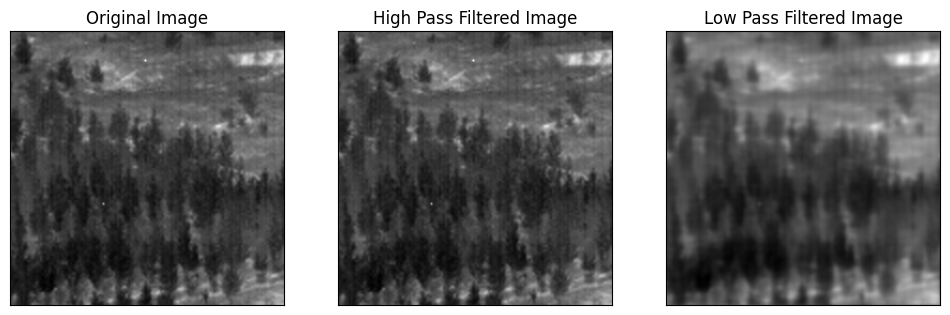

In [26]:
# 读取图像并转换为Tensor
image_path = 'W:/DataSets/ISTD/NUDT-SIRST/trainval/images/000358.png'  # 替换为你的图片路径
image = Image.open(image_path).convert('L')  # 转换为灰度图
transform = transforms.ToTensor()
tensor_image = transform(image)

# 将Tensor转换到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor_image = tensor_image.to(device)

# 对图像进行FFT变换
fft_image = torch.fft.fftn(tensor_image, dim=(-2, -1))

# 创建滤波器
def create_filter(shape, cutoff, high_pass=True):
    """ 创建一个高通或低通滤波器 """
    H, W = shape
    x, y = torch.meshgrid(torch.arange(W), torch.arange(H))
    x, y = x - (W // 2), y - (H // 2)
    distance = torch.sqrt(x**2 + y**2)
    filter_ = 1.0 - 1.0 / (1.0 + (cutoff / distance)**(2 * 4))  # Butterworth滤波器
    return filter_ if high_pass else 1.0 - filter_

# 图像尺寸
H, W = fft_image.shape[-2:]

# 设置截止频率
cutoff_high = 300  # 高通滤波器的截止频率
cutoff_low = 400   # 低通滤波器的截止频率

# 创建高通和低通滤波器
high_pass_filter = create_filter((H, W), cutoff_high, high_pass=True).to(device)
low_pass_filter = create_filter((H, W), cutoff_low, high_pass=False).to(device)

# 应用滤波器
filtered_fft_high = fft_image * high_pass_filter
filtered_fft_low = fft_image * low_pass_filter

# 通过逆FFT将频域数据转回空间域
ifft_image_high = torch.fft.ifftn(filtered_fft_high, dim=(-2, -1)).real
ifft_image_low = torch.fft.ifftn(filtered_fft_low, dim=(-2, -1)).real

# 显示结果
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(tensor_image.cpu().squeeze(0), cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(ifft_image_high.cpu().squeeze(0), cmap='gray')
plt.title('High Pass Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(ifft_image_low.cpu().squeeze(0), cmap='gray')
plt.title('Low Pass Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
from dataprocess.sirst_point import IRSTD1kDataset
import yaml
import torch.utils.data as Data

cfg_path = 'cfg.yaml'
with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

trainset = IRSTD1kDataset(base_dir=r"W:/DataSets/ISTD/IRSTD-1k", mode="train", base_size=256, pt_label=True, cfg=cfg)
train_data_loader = Data.DataLoader(trainset, batch_size=4, shuffle=False)

In [ ]:
def point2mask(img, ptlabel):
    """
    acorrding to the point,
    """

In [2]:
import torch

# a = torch.tensor([[1,2,3,4,5]], dtype=torch.float32)
# b = torch.mm(a.T, a)
b = torch.randn((1, 1, 3, 3))
print(b)
c = torch.max(b)
print(c)

tensor([[[[ 1.2352,  0.4453,  1.4749],
          [-2.1539,  0.7842, -0.6532],
          [-1.9521,  0.5438,  0.3359]]]])
tensor(1.4749)
